In [18]:
import numpy as np
from scipy.special import binom
import itertools
import networkx as nx

import perceval as pcvl
from perceval.algorithm import Sampler
import perceval.components as comp

Import of the file with the basic and auxiliary functions.

In [19]:
import functions

In [20]:
def post_selectionDSI(samples, k):
    accepted = []
    n_subg = int(len(samples[0])/2/k)
    for sample in samples:
        for i in range(n_subg):
            if all(sample[k*i:k*i+k]) == 1:
                accepted.append(sample)
    return accepted

In [21]:
def post_selectionDS(samples, k):
    n_subg = int(len(samples[0])/2/k)
    accepted = [sample for sample in samples for i in range(n_subg) if all(sample[k*i:k*i+k]) == 1]
    return accepted

In [22]:
def input_DS(m, k):
    '''input state for selection columns
             m - number of subgraphs
             k - size of each subgraph (size to identify)
        returns |1,1,1,...,0,0,0> k ones and k*m-k zeros'''
    return np.append(np.append(np.ones(k), np.zeros(k*m-k)), np.zeros(k*m)).astype(int)

In [23]:
# Functions to generate the subgraphs to test
def test_subgraphs(G, subG, size):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                size - integer for size of subgraph to find
        return:
                all remaining possible subgraphs of size "size"-len(subG)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = binom(G_n-subG_n, size-subG_n)
    print("Number of possible subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, size-subG_n))

    poss_subg = [subG+list(i) for i in test_list]
    return poss_subg

In [24]:
# Functions to generate the subgraphs to test
def construct_B(G, subG, k):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                k - integer for size of subgraph to find
        return:
                matrix B containing all possible subgraphs of size k - dimensions are k*len(sub_m), k*len(sub_m)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))
    print("Number of combinations for subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, k-subG_n))

    poss_subg = [subG+list(i) for i in test_list]

    # Construction of B
    sub_m = [nx.convert_matrix.to_numpy_array(
        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]
    B = np.zeros((k*num_subgraphs, k*num_subgraphs))
    for i, j in enumerate(sub_m):
        B[k*i:k*i+k, 0:k] = j
    return (B, poss_subg)

In [25]:
def densest_subgraphs(G, seed, k, nb_samples, Ns_min=100):
    '''Input: G - networkX graph to test 
              Ns - number of samples to generate with quantum device
              seed - subgraph identified from optimized classical algorithm
    return: subgraphs by order of selection'''

    # Initialization and preparing the device
    B = construct_B(G, seed, k)
    in_state = input_DS(int(len(B[0])/k), k)
    U, c = functions.to_unitary(B[0])

    unitary_component = comp.Unitary(pcvl.Matrix(U))
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    # generating samples
    samples = []
    i = 0
    sampler = Sampler(proc)
    while len(samples) < Ns_min:
        samples_device = sampler.samples(nb_samples)['results']
        new_generation_samples = post_selectionDS(samples_device, k)
        samples += new_generation_samples
        i = i+1

    timesG = np.zeros(len(B[1]))
    print("Number of samples: ", len(samples), "\nTotal samples generated:", nb_samples*i)
    for sample in samples:
        indexG = list(sample).index(1)
        timesG[int(indexG/k)] = timesG[int(indexG/k)]+1
    return sorted(zip(timesG, B[1]), reverse=True)

Now we are ready to test! Here you have an example.

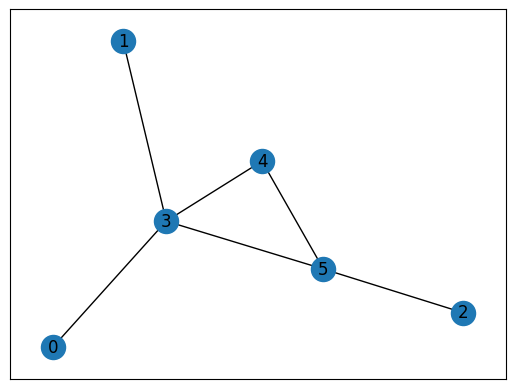

In [26]:
GA = functions.random_graph_generation(6, 0.3, 3, 1)
nx.draw_networkx(GA)

In [27]:
def plot_dense_subgraphs(ga, k, nb_samples=100, Ns_min=100):
    res = densest_subgraphs(GA, [], 3, 100, Ns_min=100)
    subgraph = res[0][-1]
    for pos in subgraph:
        nx.draw_networkx(GA.subgraph('F'), pos=pos, font_size=16, node_color='red', font_color='green')

In [28]:
%%time
res = densest_subgraphs(GA, [], 3, 100, Ns_min=100)
print(res)

Number of combinations for subgraphs: 20
Number of samples:  100 
Total samples generated: 287100
[(100.0, [3, 4, 5]), (0.0, [2, 4, 5]), (0.0, [2, 3, 5]), (0.0, [2, 3, 4]), (0.0, [1, 4, 5]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 4, 5]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
CPU times: user 9.99 s, sys: 2.74 s, total: 12.7 s
Wall time: 9.74 s


In [29]:
def delete_weakest_link(graph,chosen_edge):
    nodes = list(graph.nodes())
    graph.remove_edge(nodes[chosen_edge[0]], nodes[chosen_edge[1]])
    return graph

In [30]:
for i in range(5):
    res = densest_subgraphs(GA, [], 2, 100, Ns_min=100)
    seed = res[0][-1]
    print(seed)
    delete_weakest_link(GA,seed)

Number of combinations for subgraphs: 15
Number of samples:  103 
Total samples generated: 600
[2, 5]
Number of combinations for subgraphs: 15
Number of samples:  105 
Total samples generated: 500
[0, 3]
Number of combinations for subgraphs: 15
Number of samples:  102 
Total samples generated: 400
[4, 5]
Number of combinations for subgraphs: 15
Number of samples:  107 
Total samples generated: 300
[3, 4]
Number of combinations for subgraphs: 15
Number of samples:  101 
Total samples generated: 200
[1, 3]
